# Variational Auto Encoder Pytorch Implementation for MNSIT 

First we import the required packages.

In [191]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA


# Expermimental Set Up
The model we chosse is quite simple. We are using only linear layers with the ReLU activation function. 

In [192]:
config = {
    'model_name': 'VAE',
    'dataset': 'MNIST',
    # Variance and Mean for the weight initialization
    'weight_var': 1,
    'weight_mean': 0,
    'seed': 4,
    # Model setup 
    'input_dim': 784,
    'dims': [256, 128, 64, 32],
    'distribution_dim': 16,
    # Training setup
    'batch_size': 128,
    'num_epochs': 10,
    'learning_rate': 0.0002,
}

# DEVICE for Mac for Windows use CUDA
DEVICE = torch.device("mps")
print(DEVICE)

# Set the seed
torch.manual_seed(config['seed'])

mps


# Load Dataset 
We agreed using the MNSIT dataset first.

In [193]:

transform = transforms.Compose([transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ] )
# Batch Size comes from the config
batch_size = config['batch_size']

# DataClass 
dataset_class = getattr(datasets, config['dataset'])

# download dataset
train = dataset_class(root='./data', train=True, download=True, transform=transform)
test = dataset_class(root='./data', train=False, download=True, transform=transform)
print(len(train), len(test))

# Load dataset
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
    shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
    shuffle=True, num_workers=0)

# Print the shape of the data
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)

60000 10000
torch.Size([128, 784])


# Inisghts in the data
Always good to take a climpse at data before starting

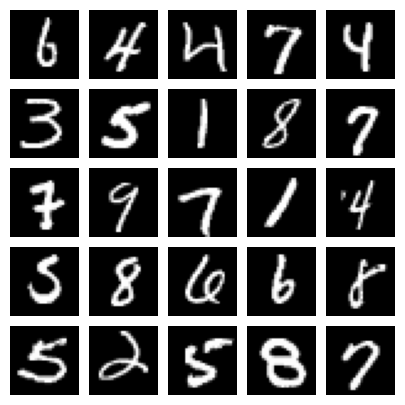

In [194]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)
# Change the shape of the image (Flatten to 2D)
image_org = image[0].view(-1, 1, 28, 28)

num_samples = 25
sample_images = [image_org[i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

# Model VAE  


In [195]:
class VAE(nn.Module):

    def __init__(self,in_dim: int,  dims: int, distribution_dim: int):
        super(VAE, self).__init__()

        self.in_dim = in_dim
        self.distribution_dim = distribution_dim
        self.dims = dims
        modules = []
        in_dim_layer = in_dim
        
        if dims is None:
            dims = [128, 256, 512]

        for h_dim in dims:
            # Create Layers 
            modules.append(
                nn.Sequential(
                # Fully connected layer
                nn.Linear(in_dim_layer, h_dim),
                # Activation Function 
                nn.ReLU())
                )
                
            in_dim_layer = h_dim 
        

        

        # Variance and Mean for the latentspace distribution
        self.mu = nn.Linear(dims[-1], distribution_dim)
        self.var = nn.Linear(dims[-1], distribution_dim)


        # Build the encoder
        self.encoder = nn.Sequential(*modules)

        
        # Build Decoder
        modules = []
        self.decoder_input = nn.Linear(distribution_dim, dims[-1])

        for i in range(len(dims) - 1, 0, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(dims[i], dims[i - 1]),
                    nn.ReLU())
            )
  

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            nn.Linear(dims[0], in_dim),
            nn.Tanh()
        )

    def encode(self, x):
        """"

        Encodes the input by passing through the encoder network
        and returns the mean and log variance of the encoded input.

        """
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)

        mu = self.mu(result)
        log_var = self.var(result)

        return [mu, log_var]

    def decode(self, z):
        """

        Takes the latent code as input and returns the reconstructed image.

        """
        result = self.decoder_input(z)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """

        Reparameterization trick to sample from N(mu, var) from
        N(0,1).

        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        """
        Passes through the encoder and decoder and returns the output.
        Using reparameterization trick to sample from the latent space.

        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
    
    def loss_function(self, x, x_reconst, mu, log_var):
        """
        Returns the loss function for the VAE.

        """
        reconst_loss = nn.functional.mse_loss(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return reconst_loss + kl_div
    
    def sample(self, num_samples):
        """
        Samples from the latent space and returns the decoded output.

        """
        with torch.no_grad():
            z = torch.randn(num_samples, self.distribution_dim)
            z = z.to(DEVICE)
            z = self.decode(z)
        return z
    
    def getLatenSpace(self, x):
        """
        Returns the latent space representation of the input. Last Layer of the Encoder before the mean and variance.
        
        """
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        return result

In [196]:

model = VAE(in_dim=784, dims=config['dims'], distribution_dim=config['distribution_dim']).to(DEVICE)
print(model)

VAE(
  (mu): Linear(in_features=32, out_features=16, bias=True)
  (var): Linear(in_features=32, out_features=16, bias=True)
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
    )
  )
  (decoder_input): Linear(in_features=16, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
 

# Training Loop


In [197]:
# Device 
#Devive = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=config['learning_rate'])
# Initialize the optimizer
print("Start training VAE...")
model.train()

for epoch in range(config['num_epochs']):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #x = x.view(config['batch_size'], config['input_dim'])
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = model.loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  237.4304209000025
	Epoch 2 complete! 	Average Loss:  185.7032700889131
	Epoch 3 complete! 	Average Loss:  169.42410596211752
	Epoch 4 complete! 	Average Loss:  152.5637109381521
	Epoch 5 complete! 	Average Loss:  138.30568615187946
	Epoch 6 complete! 	Average Loss:  129.89211058005307
	Epoch 7 complete! 	Average Loss:  123.6041075714633
	Epoch 8 complete! 	Average Loss:  117.11822424994574
	Epoch 9 complete! 	Average Loss:  113.41631349742921
	Epoch 10 complete! 	Average Loss:  110.69752898583046
Finish!!


# Safe the model 
In this case we are using the follwing name convention Dataset_ModelName_Seed_Epochs. 

In [198]:
# Save the model
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '.pth'
print(name)
# Model Path
path = './models/' + name

torch.save(model.state_dict(), path)

MNIST_VAE_4_10.pth


# Sample Pictures
In the next Code Snippet we sample directly from the latent space and decode the picture. 

In [199]:
# Sample from the model
name_pic_sample = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_' + 'sample' +'.png'
path_pic_sample = './figures/' + name_pic_sample

with torch.no_grad():
    z = torch.randn(25, config['distribution_dim']).to(DEVICE)
    sample = model.decode(z).cpu()
    save_image(sample.view(25, 1, 28, 28), path_pic_sample)

# Get Reconstruction Results

In [200]:
# Reconstruction
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Get 5 images
images = images[:25]
images = images.to(DEVICE)
images = images.view(images.size(0), -1)
name_pic = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_reconstruction.png'
path = './figures/' + name_pic
with torch.no_grad():
    # Get Sample from the model
    images_hat, _, _ = model(images)
    images_hat = images_hat.view(images.size(0), 1, 28, 28)
    comparison = torch.cat([images.view(-1, 1, 28, 28), images_hat.view(-1, 1, 28, 28)])
    save_image(comparison.cpu(),path, nrow=images.size(0))


# Plot Latent


(60000, 32)
(60000,)


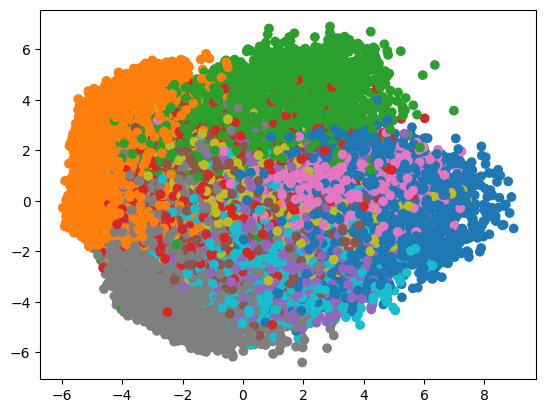

In [201]:
# Latent Space
latent_spaces = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in train_loader:
    images = images.to(DEVICE)
    images = images.view(images.size(0), -1)
    latent_space = model.getLatenSpace(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)

# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Save the plot
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_PCA.png'
path = './figures/' + name

plot.figure.savefig(path)





# tSNE